# Position Snapshots Analysis

Visualize intraday position performance to analyze optimal exit timing.

In [17]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, time
import pytz

DB_PATH = '../data/earnings_trades.db'
ET = pytz.timezone('America/New_York')

# Load snapshots
conn = sqlite3.connect(DB_PATH)
df = pd.read_sql_query("SELECT * FROM price_snapshots ORDER BY ts", conn)

# Load trades to get entry times and premium paid
trades = pd.read_sql_query("""
    SELECT trade_id, entry_datetime, earnings_date, premium_paid, contracts
    FROM trades
""", conn)
conn.close()

print(f"Loaded {len(df)} snapshots for {df['trade_id'].nunique()} trades")
df.head()

Loaded 542 snapshots for 9 trades


,id,trade_id,ts,minutes_since_open,straddle_mid,call_mid,put_mid,spot_price,unrealized_pnl,unrealized_pnl_pct,created_at
0,1,AEHR_2026-01-08_20260108200257,2026-01-09T09:30:00.007375-05:00,0,2.800,None,None,23.850,-725.0,-0.341176,2026-01-09 14:30:01
1,2,WDFC_2026-01-08_20260108200254,2026-01-09T09:30:00.007375-05:00,0,21.225,None,None,181.000,2257.5,0.270197,2026-01-09 14:30:03
2,3,AEHR_2026-01-08_20260108200257,2026-01-09T09:35:00.006291-05:00,5,2.800,None,None,22.220,-725.0,-0.341176,2026-01-09 14:35:01
3,4,WDFC_2026-01-08_20260108200254,2026-01-09T09:35:00.006291-05:00,5,23.200,None,None,177.210,3245.0,0.388390,2026-01-09 14:35:02
4,5,AEHR_2026-01-08_20260108200257,2026-01-09T09:40:00.007081-05:00,10,2.725,None,None,23.615,-762.5,-0.358824,2026-01-09 14:40:01


In [18]:
# Extract ticker from trade_id
df['ticker'] = df['trade_id'].str.split('_').str[0]
df['date'] = df['trade_id'].str.split('_').str[1]

# Convert to datetime (use ISO8601 format to handle timezone offsets)
df['ts'] = pd.to_datetime(df['ts'], format='ISO8601', utc=True)
trades['entry_datetime'] = pd.to_datetime(trades['entry_datetime'], format='ISO8601', utc=True)

# Merge to get entry time and premium for each snapshot
df = df.merge(trades[['trade_id', 'entry_datetime', 'premium_paid', 'contracts']], on='trade_id', how='left')

# Calculate entry price per contract (for % change calculation)
df['entry_price_per_contract'] = df['premium_paid'] / df['contracts'] / 100  # premium_paid is total $, straddle_mid is per share

# Filter to T+1 snapshots only (the exit day)
df['entry_date'] = df['entry_datetime'].dt.tz_convert(ET).dt.date
df['snap_date'] = df['ts'].dt.tz_convert(ET).dt.date

# Keep only snapshots where snap_date is exactly 1 day after entry_date
n_before = len(df)
df = df[df['snap_date'] > df['entry_date']]  # After entry day
days_held = (pd.to_datetime(df['snap_date']) - pd.to_datetime(df['entry_date'])).dt.days
df = df[days_held == 1]  # Exactly T+1
n_after = len(df)

# Use minutes_since_open directly (already minutes from 9:30 ET on T+1)
df['exit_day_min'] = df['minutes_since_open']

print(f"T+1 snapshots: {len(df)} (filtered {n_before - n_after} same-day/multi-day)")
print(f"Unique trades: {df['trade_id'].nunique()}")
print(df.groupby('ticker')['trade_id'].nunique())
print(f"\nTime range: {df['exit_day_min'].min():.0f} to {df['exit_day_min'].max():.0f} min from open")

T+1 snapshots: 368 (filtered 174 same-day/multi-day)
Unique trades: 6
ticker
AEHR    1
BK      1
CNXC    1
DAL     1
JPM     1
WDFC    1
Name: trade_id, dtype: int64

Time range: 0 to 385 min from open


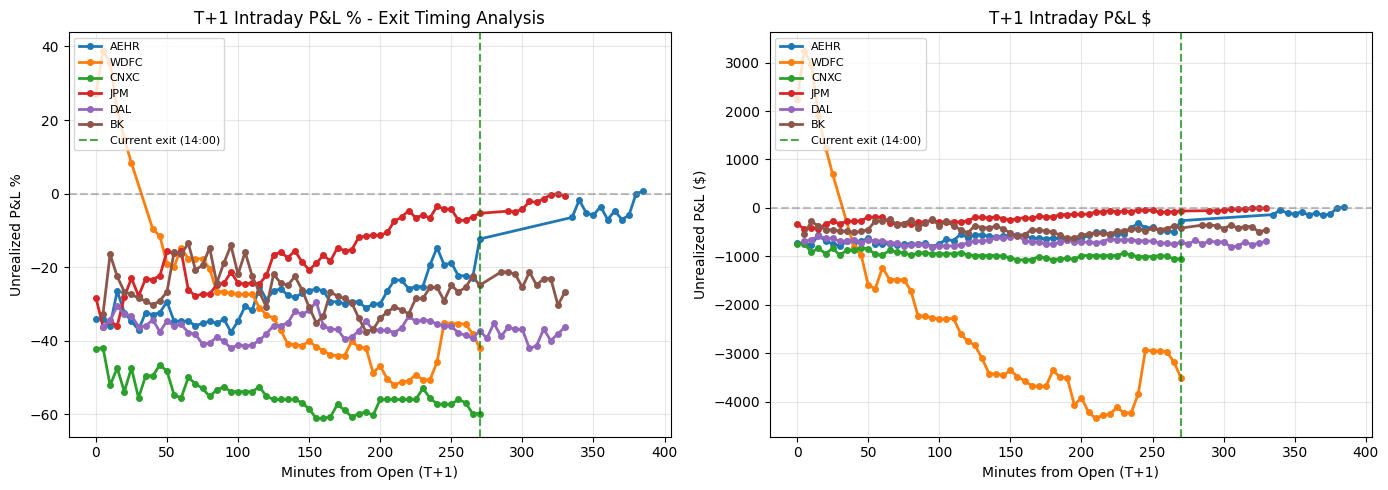

Time reference (minutes from 9:30 ET):
  0 = 9:30, 60 = 10:30, 120 = 11:30, 180 = 12:30
  240 = 13:30, 270 = 14:00 (current exit), 330 = 15:00, 390 = 16:00


In [19]:
# Plot P&L % over time on T+1 (exit day)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for trade_id in df['trade_id'].unique():
    trade_df = df[df['trade_id'] == trade_id].copy()
    ticker = trade_df['ticker'].iloc[0]
    
    axes[0].plot(trade_df['exit_day_min'], trade_df['unrealized_pnl_pct'] * 100, 
                 marker='o', label=ticker, linewidth=2, markersize=4)
    
    axes[1].plot(trade_df['exit_day_min'], trade_df['unrealized_pnl'], 
                 marker='o', label=ticker, linewidth=2, markersize=4)

# Mark current exit time (14:00 = 270 min)
for ax in axes:
    ax.axvline(x=270, color='green', linestyle='--', alpha=0.7, label='Current exit (14:00)')

axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Minutes from Open (T+1)')
axes[0].set_ylabel('Unrealized P&L %')
axes[0].set_title('T+1 Intraday P&L % - Exit Timing Analysis')
axes[0].legend(loc='upper left', fontsize=8)
axes[0].grid(True, alpha=0.3)

axes[1].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Minutes from Open (T+1)')
axes[1].set_ylabel('Unrealized P&L ($)')
axes[1].set_title('T+1 Intraday P&L $')
axes[1].legend(loc='upper left', fontsize=8)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Time reference (minutes from 9:30 ET):")
print("  0 = 9:30, 60 = 10:30, 120 = 11:30, 180 = 12:30")
print("  240 = 13:30, 270 = 14:00 (current exit), 330 = 15:00, 390 = 16:00")

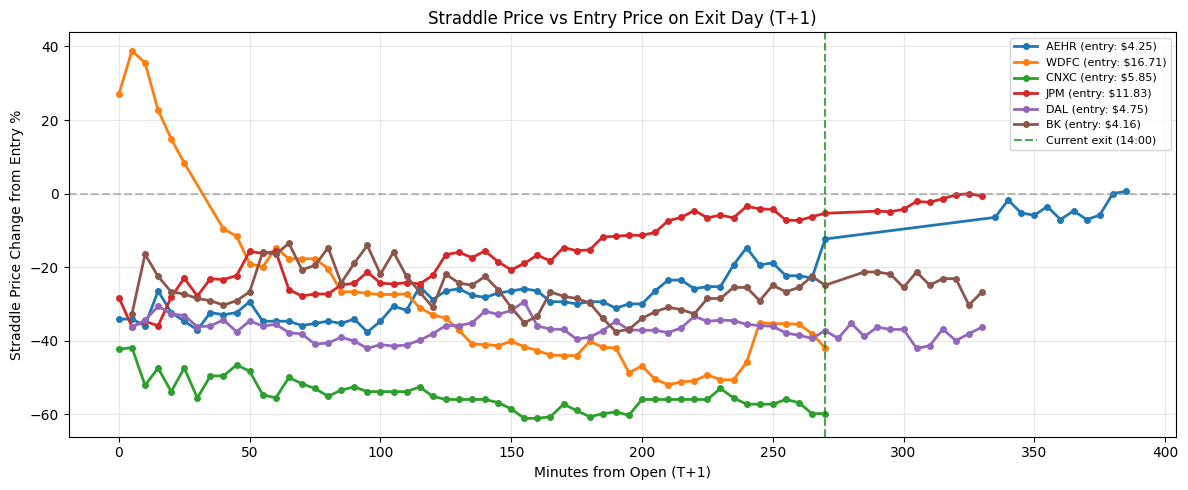

In [20]:
# Straddle mid price over time on T+1 (% change from entry price)
fig, ax = plt.subplots(figsize=(12, 5))

for trade_id in df['trade_id'].unique():
    trade_df = df[df['trade_id'] == trade_id].copy()
    ticker = trade_df['ticker'].iloc[0]
    
    # % change from entry price (what we paid)
    entry_price = trade_df['entry_price_per_contract'].iloc[0]
    pct_change = (trade_df['straddle_mid'] / entry_price - 1) * 100
    
    ax.plot(trade_df['exit_day_min'], pct_change, 
            marker='o', label=f"{ticker} (entry: ${entry_price:.2f})", linewidth=2, markersize=4)

ax.axvline(x=270, color='green', linestyle='--', alpha=0.7, label='Current exit (14:00)')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax.set_xlabel('Minutes from Open (T+1)')
ax.set_ylabel('Straddle Price Change from Entry %')
ax.set_title('Straddle Price vs Entry Price on Exit Day (T+1)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [21]:
# Summary statistics by time bucket on T+1
# Buckets for T+1 exit timing (minutes from 9:30 open)
df['time_bucket'] = pd.cut(df['exit_day_min'], 
                           bins=[0, 60, 120, 180, 240, 270, 300, 330, 360, 390],
                           labels=['9:30-10:30', '10:30-11:30', '11:30-12:30', '12:30-13:30',
                                   '13:30-14:00', '14:00-14:30', '14:30-15:00', '15:00-15:30', '15:30-16:00'])

summary = df.groupby('time_bucket', observed=True).agg({
    'unrealized_pnl': ['mean', 'sum'],
    'unrealized_pnl_pct': ['mean', 'std'],
    'trade_id': 'count'
}).round(2)

summary.columns = ['Avg P&L $', 'Total P&L $', 'Avg P&L %', 'Std P&L %', 'N Snapshots']
summary['Avg P&L %'] = (summary['Avg P&L %'] * 100).round(1)
summary['Std P&L %'] = (summary['Std P&L %'] * 100).round(1)
print("P&L by Time Bucket on T+1 (Exit Day):")
print(summary)

# Also show raw minutes breakdown
print("\n\nDetailed breakdown by 30-min intervals:")
df['min_bucket_30'] = (df['exit_day_min'] // 30) * 30
detail = df.groupby('min_bucket_30').agg({
    'unrealized_pnl_pct': 'mean',
    'trade_id': 'count'
})
detail.columns = ['Avg P&L %', 'N']
detail['Avg P&L %'] = (detail['Avg P&L %'] * 100).round(1)
print(detail)

P&L by Time Bucket on T+1 (Exit Day):
             Avg P&L $  Total P&L $  Avg P&L %  Std P&L %  N Snapshots
time_bucket                                                           
9:30-10:30     -453.81     -31766.5      -28.0       18.0           70
10:30-11:30    -854.18     -61501.0      -33.0       12.0           72
11:30-12:30   -1059.86     -76310.0      -34.0       13.0           72
12:30-13:30   -1146.34     -82536.5      -34.0       16.0           72
13:30-14:00    -953.92     -34341.0      -31.0       17.0           36
14:00-14:30    -455.04      -5915.5      -25.0       14.0           13
14:30-15:00    -390.69      -7032.5      -22.0       16.0           18
15:00-15:30    -106.25       -637.5       -5.0        2.0            6
15:30-16:00     -72.50       -362.5       -3.0        3.0            5


Detailed breakdown by 30-min intervals:
               Avg P&L %   N
min_bucket_30               
0                  -24.0  34
30                 -31.4  34
60                 -31.

In [22]:
# Best/worst times to exit on T+1
print("=== T+1 Exit Timing Analysis ===")
print("(Minutes from market open at 9:30 ET)")

print("\nBest average P&L % by exit time (30-min buckets):")
best_times = df.groupby('min_bucket_30')['unrealized_pnl_pct'].mean().sort_values(ascending=False)
print((best_times * 100).round(1).head(10))

print("\nTotal P&L $ by exit time (30-min buckets):")
total_by_time = df.groupby('min_bucket_30')['unrealized_pnl'].sum().sort_values(ascending=False)
print(total_by_time.round(0).head(10))

# Time reference
print("\n=== T+1 Timeline Reference ===")
print("  0 min   = 9:30 (open)")
print("  60 min  = 10:30")
print("  120 min = 11:30")
print("  180 min = 12:30")
print("  240 min = 13:30")
print("  270 min = 14:00 ← CURRENT EXIT TIME")
print("  330 min = 15:00")
print("  390 min = 16:00 (close)")

=== T+1 Exit Timing Analysis ===
(Minutes from market open at 9:30 ET)

Best average P&L % by exit time (30-min buckets):
min_bucket_30
360    -4.0
330   -10.8
300   -21.9
0     -24.0
270   -27.7
240   -30.6
30    -31.4
60    -31.5
90    -33.1
120   -33.2
Name: unrealized_pnl_pct, dtype: float64

Total P&L $ by exit time (30-min buckets):
min_bucket_30
360     -512.0
330    -1630.0
0      -4372.0
300    -7067.0
270   -10742.0
30    -22860.0
60    -27671.0
90    -32072.0
240   -34626.0
120   -36132.0
Name: unrealized_pnl, dtype: float64

=== T+1 Timeline Reference ===
  0 min   = 9:30 (open)
  60 min  = 10:30
  120 min = 11:30
  180 min = 12:30
  240 min = 13:30
  270 min = 14:00 ← CURRENT EXIT TIME
  330 min = 15:00
  390 min = 16:00 (close)


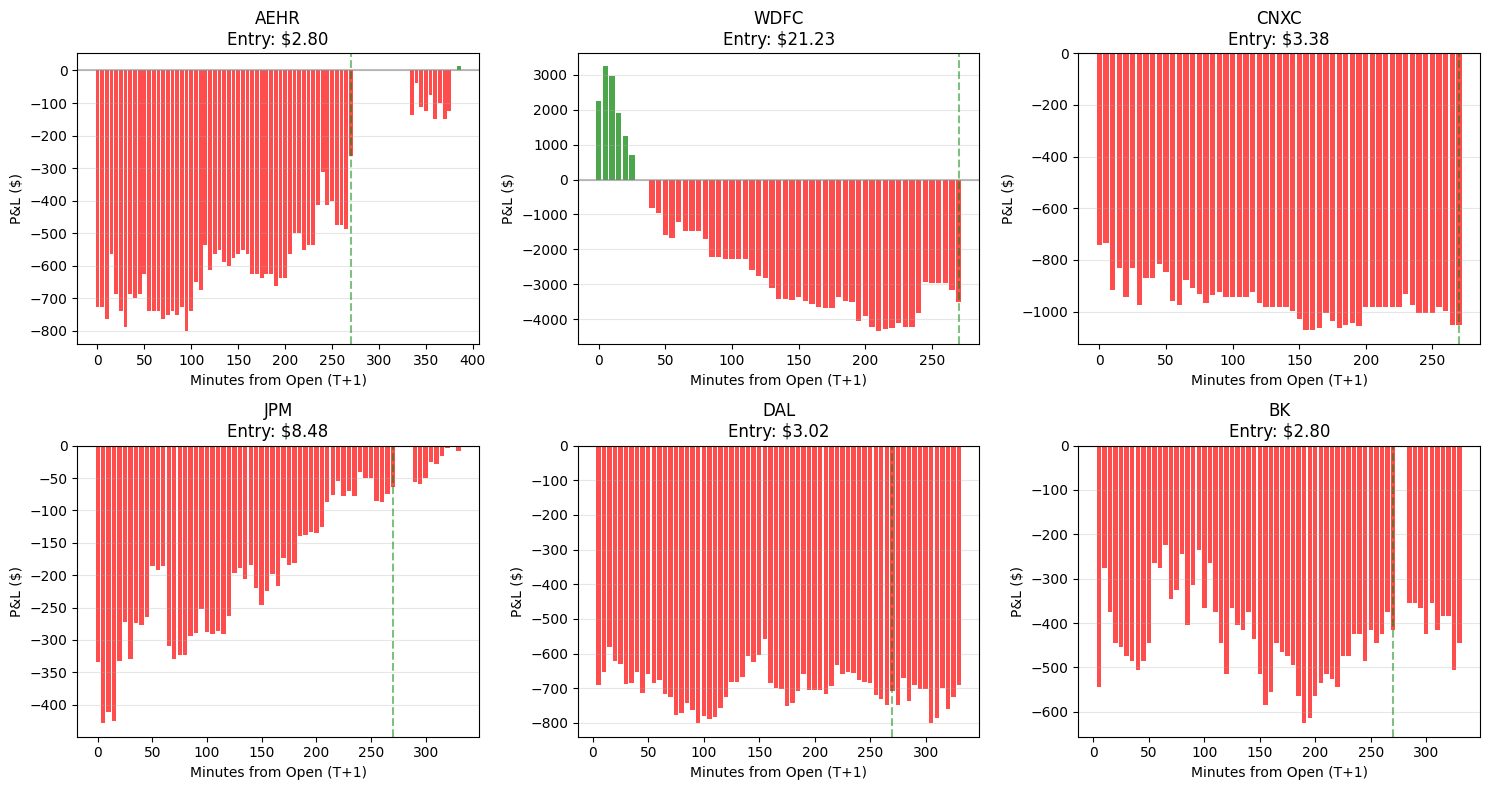

In [23]:
# Individual trade curves on T+1
n_trades = df['trade_id'].nunique()
ncols = min(3, n_trades)
nrows = (n_trades + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
axes = np.array(axes).flatten() if n_trades > 1 else [axes]

for i, trade_id in enumerate(df['trade_id'].unique()):
    trade_df = df[df['trade_id'] == trade_id].copy()
    ticker = trade_df['ticker'].iloc[0]
    
    ax = axes[i]
    
    # Plot P&L with color based on value
    colors = ['green' if x >= 0 else 'red' for x in trade_df['unrealized_pnl']]
    ax.bar(trade_df['exit_day_min'], trade_df['unrealized_pnl'], 
           color=colors, alpha=0.7, width=4)
    
    ax.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax.axvline(x=270, color='green', linestyle='--', alpha=0.5, label='Exit (14:00)')
    ax.set_xlabel('Minutes from Open (T+1)')
    ax.set_ylabel('P&L ($)')
    ax.set_title(f'{ticker}\nEntry: ${trade_df["straddle_mid"].iloc[0]:.2f}')
    ax.grid(True, alpha=0.3, axis='y')

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [24]:
# Load actual exit data for comparison
conn = sqlite3.connect(DB_PATH)
trades_df = pd.read_sql_query("""
    SELECT trade_id, ticker, premium_paid, exit_pnl, exit_pnl_pct, 
           realized_move_pct, implied_move, exit_datetime
    FROM trades 
    WHERE status = 'exited' AND exit_pnl IS NOT NULL
""", conn)
conn.close()

print(f"Completed trades: {len(trades_df)}")
trades_df

Completed trades: 15


,trade_id,ticker,premium_paid,exit_pnl,exit_pnl_pct,realized_move_pct,implied_move,exit_datetime
0,PENG_2026-01-06_20260106204607,PENG,2011.0275,-11.54,-0.005738,NaN,0.183380,2026-01-07T19:52:04
1,CALM_2026-01-07_20260106204608,CALM,2853.4875,-1206.59,-0.422847,NaN,0.071601,2026-01-07T19:51:41
2,STZ_2026-01-07_20260107200500,STZ,3900.0000,-1050.00,-0.269231,NaN,0.055634,2026-01-08T20:02:16.079767
3,JEF_2026-01-07_20260107200501,JEF,2350.0000,-350.00,-0.148936,NaN,0.071494,2026-01-08T20:02:16.079767
4,APLD_2026-01-07_20260107200503,APLD,2200.0000,-885.00,-0.402273,NaN,0.148161,2026-01-08T20:02:16.079767
5,AYI_2026-01-08_20260107200504,AYI,13975.0000,9925.00,0.710197,NaN,0.076120,2026-01-08T20:02:16.079767
6,HELE_2026-01-08_20260107200505,HELE,1950.0000,-875.00,-0.448718,NaN,0.184426,2026-01-08T20:02:16.079767
7,STZ_2026-01-07_20260107201729,STZ,3900.0000,-1050.00,-0.269231,NaN,0.055210,2026-01-08T20:02:16.079767
8,JEF_2026-01-07_20260107201730,JEF,2350.0000,-350.00,-0.148936,NaN,0.072475,2026-01-08T20:02:16.079767
9,APLD_2026-01-07_20260107201732,APLD,2165.0000,-850.00,-0.392610,NaN,0.144536,2026-01-08T20:02:16.079767


In [25]:
# Compare: What if we exited at different times on T+1?
print("=== T+1 What-If Exit Analysis ===")
print("(Minutes from 9:30 ET open)")

for trade_id in df['trade_id'].unique():
    trade_df = df[df['trade_id'] == trade_id].copy()
    ticker = trade_df['ticker'].iloc[0]
    
    # Find actual exit P&L if available
    actual = trades_df[trades_df['trade_id'] == trade_id]
    actual_pnl = actual['exit_pnl'].iloc[0] if len(actual) > 0 else None
    
    best_idx = trade_df['unrealized_pnl'].idxmax()
    worst_idx = trade_df['unrealized_pnl'].idxmin()
    
    # Convert minutes to time
    def min_to_time(m):
        h = int(9 + m // 60)
        mm = int((30 + m) % 60)
        return f"{h:02d}:{mm:02d}"
    
    print(f"\n{ticker}:")
    best_min = trade_df.loc[best_idx, 'exit_day_min']
    worst_min = trade_df.loc[worst_idx, 'exit_day_min']
    last_min = trade_df['exit_day_min'].iloc[-1]
    
    print(f"  Best intraday P&L:  ${trade_df['unrealized_pnl'].max():,.0f} at {min_to_time(best_min)} ({best_min:.0f} min)")
    print(f"  Worst intraday P&L: ${trade_df['unrealized_pnl'].min():,.0f} at {min_to_time(worst_min)} ({worst_min:.0f} min)")
    print(f"  Latest snapshot:    ${trade_df['unrealized_pnl'].iloc[-1]:,.0f} at {min_to_time(last_min)} ({last_min:.0f} min)")
    if actual_pnl is not None:
        print(f"  Actual exit P&L:    ${actual_pnl:,.0f}")

=== T+1 What-If Exit Analysis ===
(Minutes from 9:30 ET open)

AEHR:
  Best intraday P&L:  $13 at 15:55 (385 min)
  Worst intraday P&L: $-800 at 10:05 (95 min)
  Latest snapshot:    $13 at 15:55 (385 min)
  Actual exit P&L:    $-262

WDFC:
  Best intraday P&L:  $3,245 at 09:35 (5 min)
  Worst intraday P&L: $-4,342 at 12:00 (210 min)
  Latest snapshot:    $-3,505 at 13:00 (270 min)

CNXC:
  Best intraday P&L:  $-735 at 09:35 (5 min)
  Worst intraday P&L: $-1,072 at 11:05 (155 min)
  Latest snapshot:    $-1,050 at 13:00 (270 min)

JPM:
  Best intraday P&L:  $-1 at 14:55 (325 min)
  Worst intraday P&L: $-428 at 09:35 (5 min)
  Latest snapshot:    $-8 at 14:00 (330 min)
  Actual exit P&L:    $-93

DAL:
  Best intraday P&L:  $-558 at 11:05 (155 min)
  Worst intraday P&L: $-800 at 10:05 (95 min)
  Latest snapshot:    $-690 at 14:00 (330 min)
  Actual exit P&L:    $-738

BK:
  Best intraday P&L:  $-225 at 10:35 (65 min)
  Worst intraday P&L: $-625 at 12:40 (190 min)
  Latest snapshot:    $-44